In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import tqdm.notebook as tqdm

data = pd.read_csv("data/All_not_null/55285839-9b78-48d8-9f4e-573190ace016_data.csv")
data.sort_values('created_at')


# Use only the 'rms_xyz' for univariate modeling
target = data[['imbalance_health']]
data = data[['rms_xyz']]

# Show the head of the data
print(data.head())
print(target.head())

    rms_xyz
0  0.030053
1  0.255366
2  0.026734
3  0.026723
4  0.335299
   imbalance_health
0          0.924009
1          0.924009
2          0.924009
3          0.924009
4          0.924009


In [2]:
# Normalize the closing price
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.values)
target_scaled = scaler.fit_transform(target.values)

# Convert to a PyTorch tensor
data_scaled = torch.FloatTensor(data_scaled).view(-1)
target_tensor = torch.FloatTensor(target_scaled).view(-1)

In [3]:
type(data_scaled), data_scaled.shape

(torch.Tensor, torch.Size([2515]))

In [4]:
type(target_tensor), target_tensor.shape

(torch.Tensor, torch.Size([2515]))

In [5]:
# Create sequences for training
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = target_tensor[i + seq_length]
        sequences.append((seq, label))
    return sequences

SEQ_LENGTH = 12  # Use the past 12 sequence to predict the one day
sequences = create_sequences(data_scaled, SEQ_LENGTH)

In [6]:
# Split into training and testing datasets (80% train, 20% test)
train_size = int(len(sequences) * 0.8)
train_sequences = sequences[:train_size]
test_sequences = sequences[train_size:]

type(train_sequences), type(test_sequences)

(list, list)

In [7]:
# Unpack the sequences into separate tensors for features and labels
train_sequences_features = [seq for seq, label in train_sequences]
train_sequences_labels = [label for seq, label in train_sequences]

test_sequences_features = [seq for seq, label in test_sequences]
test_sequences_labels = [label for seq, label in test_sequences]

# Convert lists to tensors
train_features_tensor = torch.stack(train_sequences_features)
train_labels_tensor = torch.stack(train_sequences_labels)

test_features_tensor = torch.stack(test_sequences_features)
test_labels_tensor = torch.stack(test_sequences_labels)

In [8]:
# Create TensorDatasets for training and testing
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

# Create DataLoaders for training and testing datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [9]:
# Print a sample from the training data to confirm it's working
sample_train_data = next(iter(train_loader))
# print(f"Sample training data batch: {sample_train_data}")

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)  # Use batch_first=True
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)  # Remove hidden_cell to allow PyTorch to manage it internally
        predictions = self.linear(lstm_out[:, -1])  # Use only the output from the last timestep
        return predictions

In [11]:
def train_model(model, train_loader, epochs=10, lr=0.0001, model_path='best_uni_model.pth'):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    best_loss = float('inf')  # Initialize the best loss as infinity

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for seq, labels in train_loader:
            optimizer.zero_grad()

            # Ensure seq has the correct shape (batch_size, seq_len, input_size)
            seq = seq.unsqueeze(-1)  # Adding the feature dimension
            y_pred = model(seq)

            loss = loss_function(y_pred, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        average_loss = epoch_loss / len(train_loader)
        if (epoch +1) % epochs == 0 : 
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {average_loss}')

        # Save the model if the average training loss is the best so far
        if average_loss < best_loss:
            best_loss = average_loss
            torch.save(model.state_dict(), model_path)
            print(f'Best model saved with Training Loss: {best_loss}')

# Initialize the model
model = LSTMModel()

# Train the model
train_model(model, train_loader, epochs=500)

C:\Users\user\anaconda3\envs\torch-gpu\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\user\anaconda3\envs\torch-gpu\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Training Loss: 0.8052177671343088
Best model saved with Training Loss: 0.8052177671343088
Epoch 2/500, Training Loss: 0.6725146844983101
Best model saved with Training Loss: 0.6725146844983101
Epoch 3/500, Training Loss: 0.4574106130748987
Best model saved with Training Loss: 0.4574106130748987
Epoch 4/500, Training Loss: 0.09782807406736538
Best model saved with Training Loss: 0.09782807406736538
Epoch 5/500, Training Loss: 0.017844349451479502
Best model saved with Training Loss: 0.017844349451479502
Epoch 6/500, Training Loss: 0.016003946846467443
Best model saved with Training Loss: 0.016003946846467443
Epoch 7/500, Training Loss: 0.015745891265396494
Best model saved with Training Loss: 0.015745891265396494
Epoch 8/500, Training Loss: 0.015830184245714918
Epoch 9/500, Training Loss: 0.015554387704469264
Best model saved with Training Loss: 0.015554387704469264
Epoch 10/500, Training Loss: 0.015489729405089747
Best model saved with Training Loss: 0.015489729405089747
E

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [13]:
def plot_predictions(predictions, actuals, num_plots=100):
    plt.figure(figsize=(12,6))
    plt.plot(actuals[:num_plots], label='Actual Value', color='blue')
    plt.plot(predictions[:num_plots], label='Predicted Value', color='red')
    plt.title(f'{data.columns[0]} Prediction')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [14]:
def evaluate_model(model, test_loader, scaler, device='cpu', model_path='best_uni_model.pth'):
    model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
    model.to(device)
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for seq, labels in test_loader:
            seq = seq.to(device)
            labels = labels.to(device)
            # Ensure seq has the correct shape (batch_size, seq_len, input_size)
            seq = seq.unsqueeze(-1)  # Adding the feature dimension
            y_pred = model(seq)
            predictions.append(y_pred.cpu().numpy())
            actuals.append(labels.cpu().numpy())

    # Concatenate all batches
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)


     # Reshape predictions and actuals to 2D arrays if necessary
    if predictions.ndim == 1:  # Check if the data is 1D
        predictions = predictions.reshape(-1, 1)
    if actuals.ndim == 1:  # Check if the data is 1D
        actuals = actuals.reshape(-1, 1)
        
    # Inverse transform to original scale
    predictions = scaler.inverse_transform(predictions)
    actuals = scaler.inverse_transform(actuals)

    return predictions, actuals

In [15]:
predictions, actuals = evaluate_model(model, test_loader, scaler, device)

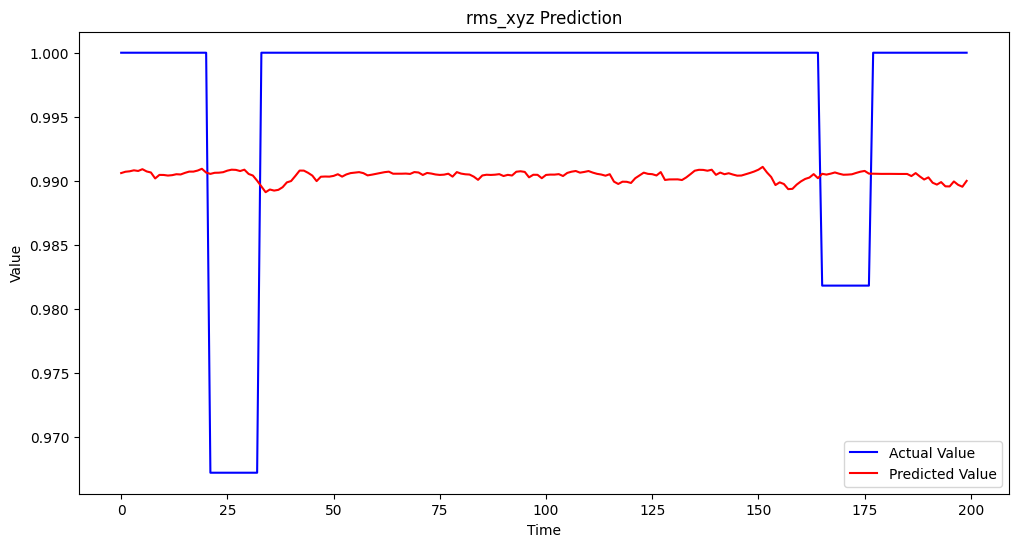

In [16]:
# Plot the predictions vs actualsprint("Plotting the results...")
plot_predictions(predictions, actuals, num_plots=200)  # Adjust num_plots as needed